# Part 3: Regression for joint angles

In this phase of the project, we will focus exclusively on Subject 1 from the NinaPro Dataset 8. Unlike classification, the objective here is regression, aiming 
to predict joint angles based on input EMG data.

In [101]:
import joblib
import pandas as pd
import seaborn as sns
from scipy.io import loadmat 

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from functions import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3.1. Visualization and Preprocessing

### Load the data

In [102]:
base_zip_path = '../data/'
mat_train_data = loadmat(base_zip_path + 'S1_E1_A1.mat')
mat_val_data = loadmat(base_zip_path + 'S1_E1_A2.mat')
mat_test_data = loadmat(base_zip_path + 'S1_E1_A3.mat')
print(f"Dataset variables: {mat_train_data.keys()}")

Dataset variables: dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'emg', 'acc', 'gyro', 'mag', 'glove', 'stimulus', 'repetition', 'restimulus', 'rerepetition'])


In [ ]:
emg_train_data = mat_train_data['emg']
emg_val_data = mat_val_data['emg']
emg_test_data = mat_test_data['emg']
n_electrodes = emg_train_data.shape[1]
n_joints = 5
glove_train_data_index = mat_train_data['glove'][:,[2,5,7,10,13]]
glove_val_data_index = mat_val_data['glove'][:,[2,5,7,10,13]]
glove_test_data_index = mat_test_data['glove'][:,[2,5,7,10,13]]

### Visualize the data

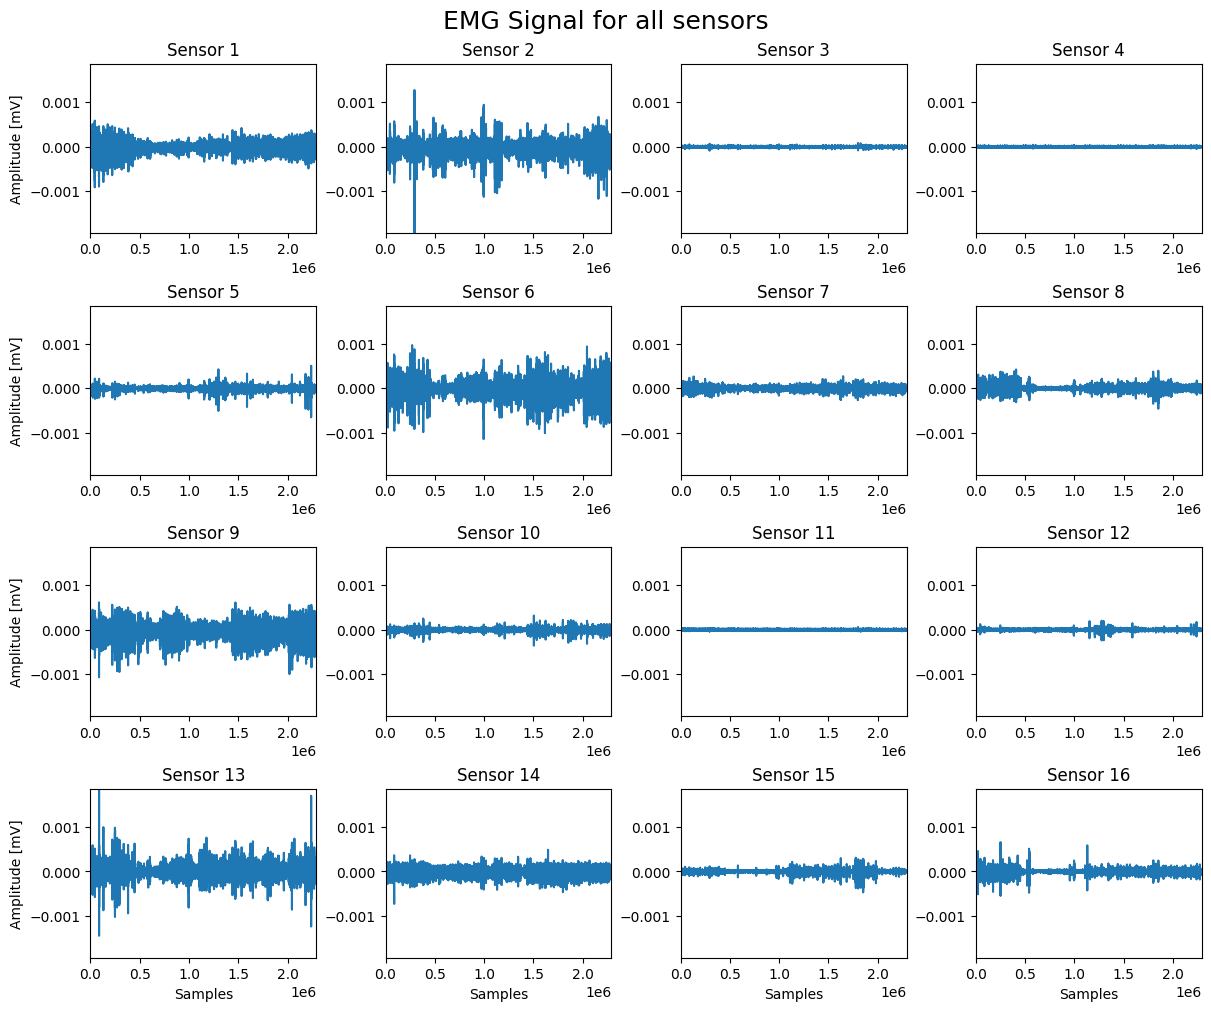

In [105]:
# Define the number of rows and columns for the subplot grid
n_rows, n_cols = 4, 4

# Create the subplots with the specified layout
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 10), constrained_layout=True)
axs = axs.ravel()

# Get the y-axis limits
y_lower_limit = np.min(emg_train_data)
y_upper_limit = np.max(emg_train_data)

# Plot each electrode's data in a separate subplot
for i in range(n_electrodes):
    axs[i].plot(emg_train_data[:, i])
    axs[i].set_title(f'Sensor {i + 1}')
    axs[i].set_xlim(0, emg_train_data.shape[0])
    axs[i].set_ylim(y_lower_limit, y_upper_limit)
    if i % n_cols == 0:  # Leftmost column
        axs[i].set_ylabel("Amplitude [mV]", fontsize=10)
    if i >= (n_rows - 1) * n_cols:  # Bottom row
        axs[i].set_xlabel("Samples", fontsize=10)

# Hide any unused subplots
for j in range(n_electrodes, n_rows * n_cols):
    fig.delaxes(axs[j])

# Add a main title to the figure
plt.suptitle("EMG Signal for all sensors", fontsize=18)

# Show the plot
plt.show()

We observe that some electrodes exhibit lower amplitude signals; however, the standard deviations appear to be of the same order of magnitude, suggesting that all sensors were functioning properly. According to the Ninapro dataset documentation (https://ninapro.hevs.ch/instructions/DB8.html), the data has already been preprocessed. Therefore, no further preprocessing is required.

Let’s examine the frequency domain!

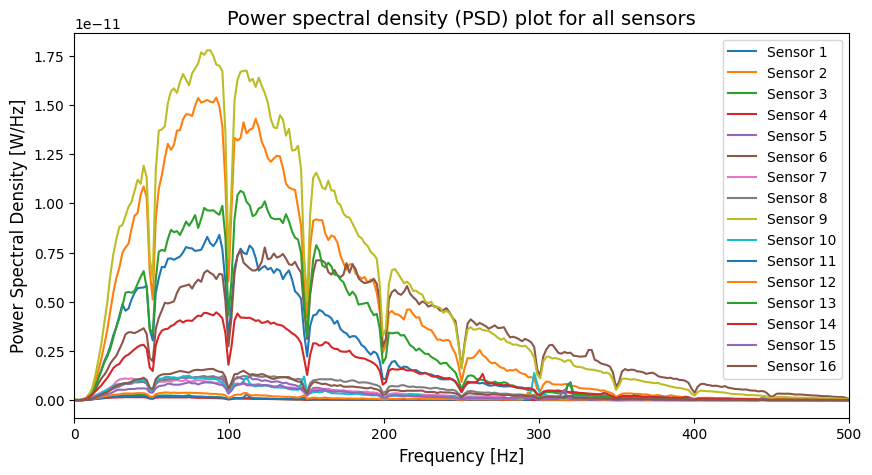

In [106]:
fs = 2000
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(n_electrodes):
    f, Pxx = welch(emg_train_data[:, i], fs, nperseg=1024)
    ax.plot(f, Pxx, label="Sensor {}".format(i+1))
ax.set_xlim(0, 500)
ax.set_xlabel("Frequency [Hz]", fontsize=12)
ax.set_ylabel("Power Spectral Density [W/Hz]", fontsize=12)
plt.title('Power spectral density (PSD) plot for all sensors', fontsize=14)
ax.legend(prop={'size': 10})
plt.show()

The preprocessing performed by Ninapro includes power grid noise removal, as evidenced by the noticeable reductions in the 50 Hz harmonic frequencies.

We can have a look at the glove data !

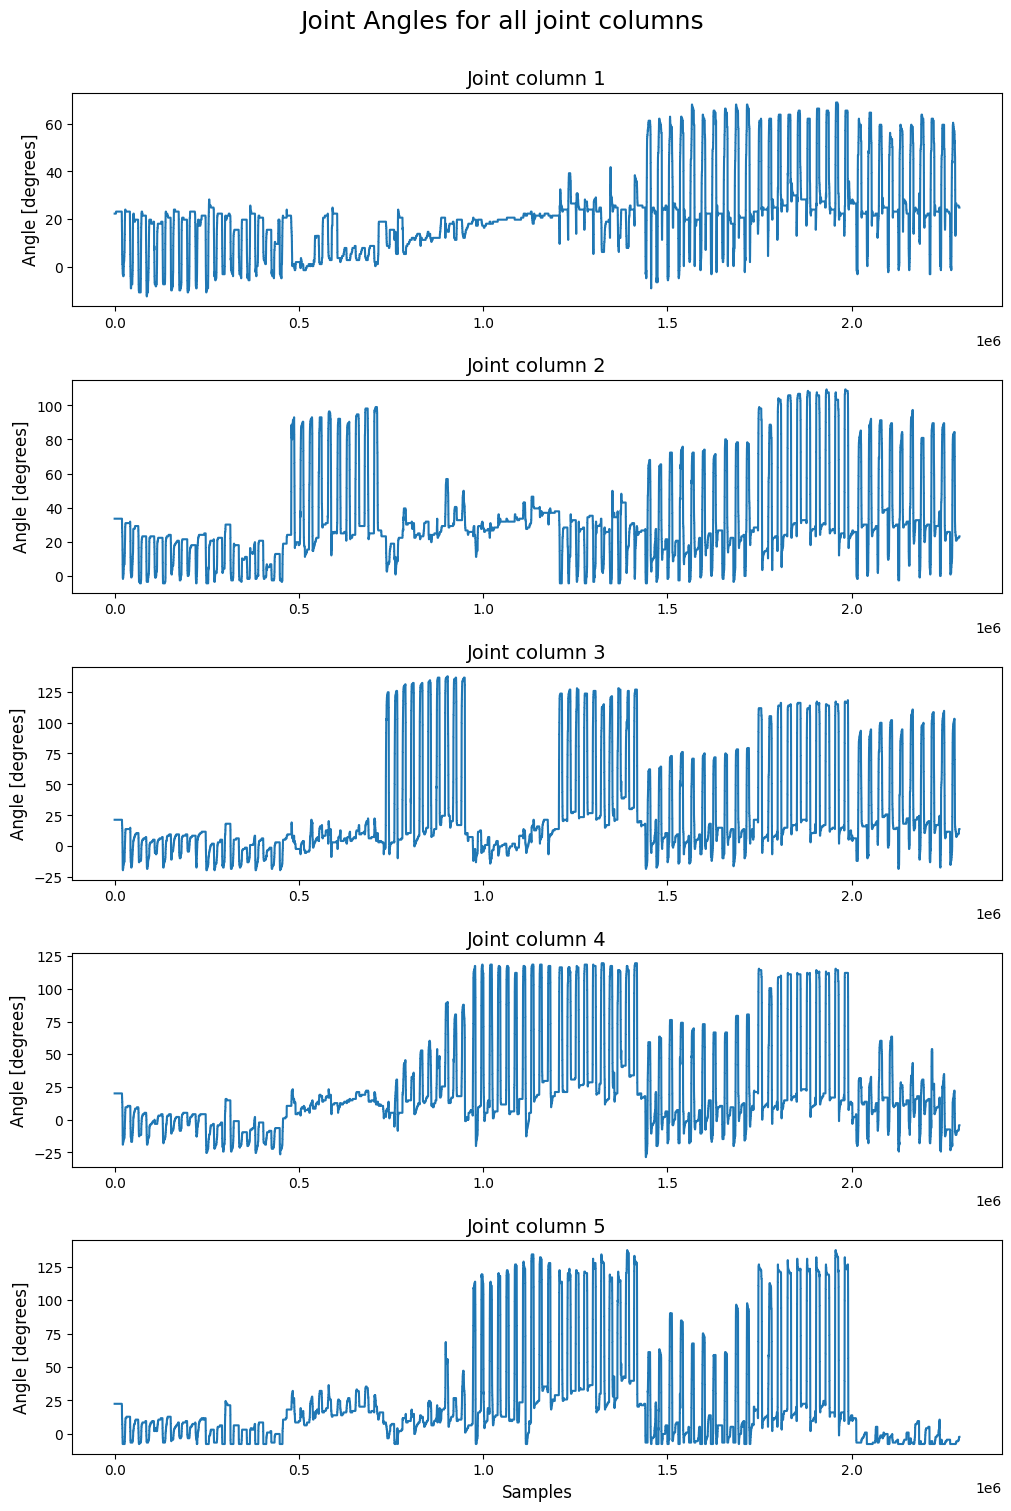

In [107]:
# Define the number of rows and columns for the subplot grid
n_rows, n_cols = 5, 1

# Create the subplots with the specified layout
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 15), constrained_layout=True)
axs = axs.ravel()

# Plot each joint's data in a separate subplot
for i in range(n_joints):
    axs[i].plot(glove_train_data_index[:, i])
    axs[i].set_title(f"Joint column {i+1}", fontsize=14)
    axs[i].set_ylabel("Angle [degrees]", fontsize=12)
    if i == n_joints - 1:  # Bottom row
        axs[i].set_xlabel("Samples", fontsize=12)

# Hide any unused subplots
for j in range(n_joints, n_rows * n_cols):
    fig.delaxes(axs[j])

# Add a main title to the figure
plt.suptitle("Joint Angles for all joint columns \n", fontsize=18)

# Show the plot
plt.show()

### Spliting dataset

Time series data requires careful splitting to prevent data leakage. The splitting process must ensure that same data that are in two different windows are not in two different sets. To maintain consistency, we followed the dataset documentation's recommendations and used separate datasets for training, validation, and testing.

Additionally, it is essential to define a time window and step size for feature extraction. A smaller time window can capture finer details but risks amplifying noise and losing signal fidelity if the window is too short. The step size, on the other hand, is chosen with computational efficiency in mind.

For this analysis, we selected a window size of 128 ms and a step size of 50 ms. These values align with those used in the Ninapro paper for regression tasks (Krasoulis et al., Effect of user adaptation on prosthetic finger control with an intuitive myoelectric decoder. Frontiers in Neuroscience, 2019, https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2019.00891/full#B6).

In [108]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [109]:
emg_window_length_sec = 128e-3  # [s]
incremental_window_length_sec =50e-3  # [s]

# extract over lapping time windows on the whole dataset before splitting the dataset into train, validation and test
EMG_windows_train, Labels_windows_train = extract_time_windows_regression(emg_train_data, glove_train_data_index, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_windows_val, Labels_windows_val = extract_time_windows_regression(emg_val_data, glove_val_data_index, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_windows_test, Labels_windows_test = extract_time_windows_regression(emg_test_data, glove_test_data_index, fs, emg_window_length_sec, incremental_window_length_sec)

print(f"EMG train data shape: {EMG_windows_train.shape}")
print(f"Labels train data shape: {Labels_windows_train.shape}")
print(f"EMG validation data shape: {EMG_windows_val.shape}")
print(f"Labels validation data shape: {Labels_windows_val.shape}")
print(f"EMG test data shape: {EMG_windows_test.shape}")
print(f"Labels test data shape: {Labels_windows_test.shape}")

EMG train data shape: (22923, 256, 16)
Labels train data shape: (22923, 256, 5)
EMG validation data shape: (23133, 256, 16)
Labels validation data shape: (23133, 256, 5)
EMG test data shape: (5289, 256, 16)
Labels test data shape: (5289, 256, 5)


### Features 

To train our regressor, it is important to carefully select the features. Several factors must be considered when choosing the appropriate features. First, we need to include a sufficient number of features to ensure the model can accurately fit the data, while avoiding the risk of overfitting. Second, we must minimize redundancy between features, as features that provide no additional information can negatively impact the regressor's performance. Lastly, the nature of the data itself must be taken into account.

Since we are working with time series data and using small time windows of 128 ms, features derived from the frequency domain may introduce inconsistencies and issues related to boundary conditions. For this reason, we selected features such as waveform length (WL), slope sign change (SSC), auto-regressive coefficient 1, Wilson Amplitude, and log variance. For the labels, we calculated the mean value within each window. These features were chosen because they are also utilized in regression methods in the Ninapro paper (Krasoulis et al., Effect of user adaptation on prosthetic finger control with an intuitive myoelectric decoder. Frontiers in Neuroscience, 2019, https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2019.00891/full#B6).

In [110]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    EMG_wl = np.apply_along_axis(wl, 1, EMG_windows)
    EMG_ssc = np.apply_along_axis(ssc, 1, EMG_windows)
    EMG_wilson_amplitude = np.apply_along_axis(wilson_amplitude, 1, EMG_windows)
    EMG_log_variance = np.apply_along_axis(log_variance, 1, EMG_windows)
    EMG_ar_coeff = np.apply_along_axis(ar_coefficients, 1, EMG_windows)
    EMG_ar_coeff1 = EMG_ar_coeff[:,0,:]
    Labels_mean = np.mean(Labels_windows, axis=1)

    
    EMG_extracted_features = np.concatenate((EMG_wl, EMG_ssc, EMG_wilson_amplitude, EMG_log_variance, EMG_ar_coeff1), axis=1)
    return EMG_extracted_features, Labels_mean

/Users/charlesboissier/bio/NSSP/NSSP_Project2/scripts/functions.py:150: RuntimeWarning: invalid value encountered in divide
  
/Users/charlesboissier/bio/NSSP/NSSP_Project2/scripts/functions.py:150: RuntimeWarning: invalid value encountered in divide
  


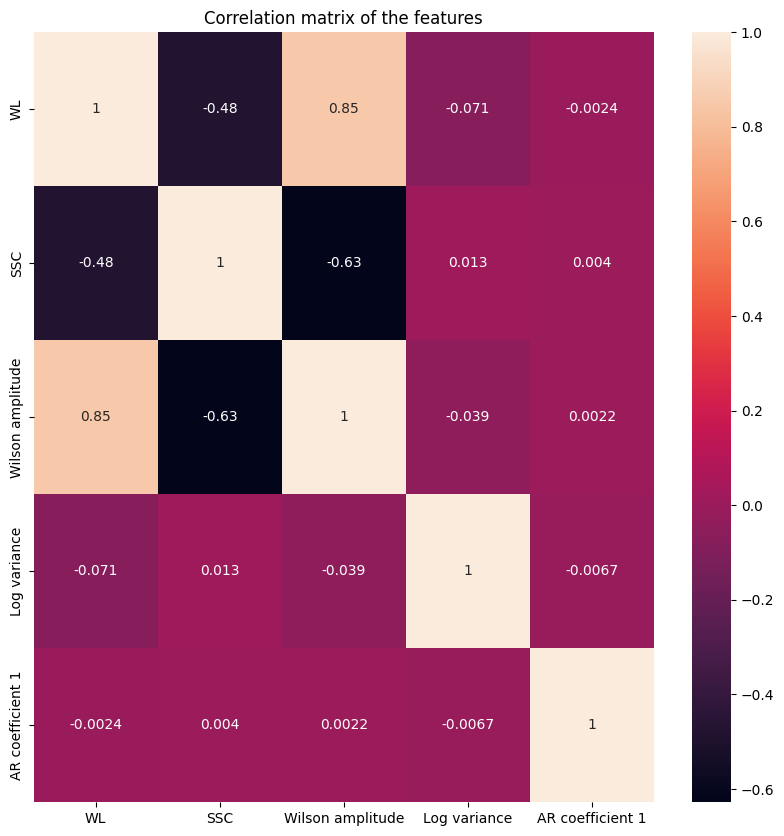

EMG train extracted features shape: (22923, 80), Finger labels feature shape:(22923, 5)
EMG val extracted features shape: (23133, 80), Finger labels feature shape:(23133, 5)
EMG test extracted features shape: (5289, 80), Finger labels feature shape:(5289, 5)


In [111]:
# Extract features for training and testing data
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_windows_train, Labels_windows_train)
EMG_val_extracted_features, Labels_val_mean = extract_features(EMG_windows_val, Labels_windows_val)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_windows_test, Labels_windows_test)

# Normalize features
scaler = StandardScaler()
scaler.fit(EMG_train_extracted_features)
EMG_train_extracted_features = scaler.transform(EMG_train_extracted_features)
EMG_val_extracted_features = scaler.transform(EMG_val_extracted_features)
EMG_test_extracted_features = scaler.transform(EMG_test_extracted_features)

# Calculate correlation matrix
correlation_mean = []
for i in range(n_electrodes):
    correlation_per_electrode = EMG_train_extracted_features[:, i::n_electrodes]
    correlation = np.corrcoef(correlation_per_electrode.T)
    correlation_mean.append(correlation)

correlation_mean = np.mean(correlation_mean, axis=0)

# Define feature names
features_names = ["WL", "SSC", "Wilson amplitude", "Log variance", "AR coefficient 1"]

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation_mean, annot=True, xticklabels=features_names, yticklabels=features_names, ax=ax)
plt.title("Correlation matrix of the features")
plt.show()

# Print shapes of extracted features and labels
print("EMG train extracted features shape: {}, Finger labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG val extracted features shape: {}, Finger labels feature shape:{}".format(EMG_val_extracted_features.shape, Labels_val_mean.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

Overall, the correlation between features are quite low. Therefore we can use them for the regression.

### Regression 

For this part we train our Regressor. In our case the regressor is a Random Forest Regressor, since we have specific sets, we cannot simply use GridSearch with cross-validation. To solve this issue we do the grid search manually and use R2 metrics to compare the models

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Best score: 0.6173317381845801


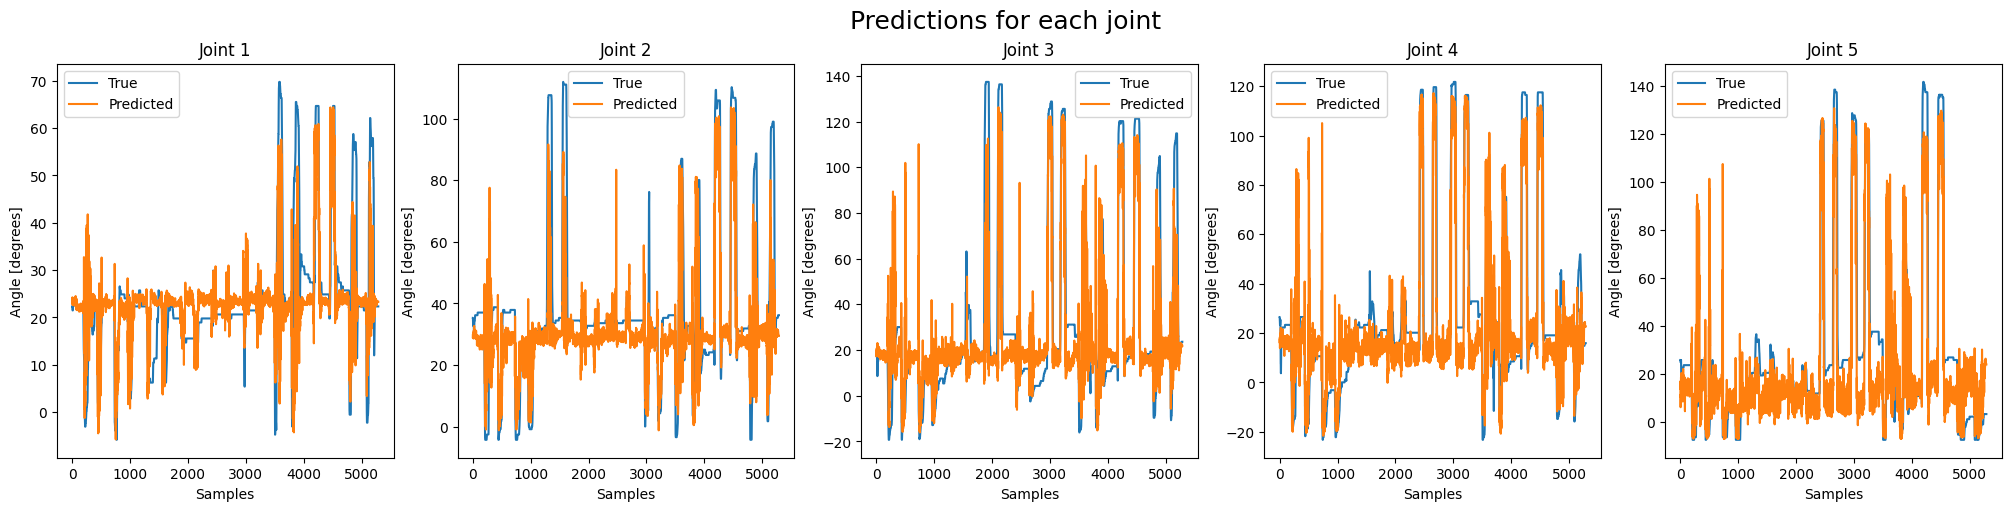

In [120]:
# Fit a RandomForest regressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5],
    'min_samples_split': [2,5, 10],
    'min_samples_leaf': [1, 4, 10],
}

#Manual grid search and plot manual grid search results
best_score = 0
results = []
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                rf.fit(EMG_train_extracted_features, Labels_train_mean)
                score = rf.score(EMG_val_extracted_features, Labels_val_mean)
                if score > best_score:
                    best_score = score
                    best_rf = rf
                results.append([n_estimators, max_depth, min_samples_split, min_samples_leaf, score])                
# Print the best parameters
print(f"Best parameters: {best_rf.get_params()}")
print(f"Best score: {best_score}")

# Save the model
joblib.dump(best_rf, "best_rf_model.pkl")

# Metrics
train_predictions = best_rf.predict(EMG_train_extracted_features)
val_predictions = best_rf.predict(EMG_val_extracted_features)
test_predictions = best_rf.predict(EMG_test_extracted_features)

# Plot the predictions for each joint individually
fig, axs = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)
for i in range(n_joints):
    axs[i].plot(Labels_test_mean[:, i], label="True")
    axs[i].plot(test_predictions[:, i], label="Predicted")
    axs[i].set_title(f"Joint {i+1}")
    axs[i].set_xlabel("Samples")
    axs[i].set_ylabel("Angle [degrees]")
    axs[i].legend()

plt.suptitle("Predictions for each joint", fontsize=18)
plt.show()

Looking at the graph we see that the actual and predicted data are indeed following the same trend.

In [123]:
# plot the results per parameter combination in a table
results_df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'score'])
results_df = results_df.sort_values(by='score', ascending=False)
print(results_df)



   n_estimators max_depth min_samples_split min_samples_leaf     score
39          200       nan                 5                1  0.617332
18          100       nan                 2                1  0.615522
36          200       nan                 2                1  0.614889
37          200       nan                 2                4  0.614467
21          100       nan                 5                1  0.613967
42          200       nan                10                1  0.613841
4            50       nan                 5                4  0.612602
7            50       nan                10                4  0.612298
24          100       nan                10                1  0.612285
43          200       nan                10                4  0.611741
19          100       nan                 2                4  0.611540
22          100       nan                 5                4  0.611200
40          200       nan                 5                4  0.611157
0     

### Evaluation 

To evaluate the performance of our regressor, we used three metrics: MSE, R2, and adjusted R2.

- **MSE (Mean Squared Error)** provides insight when tuning parameters and selecting between models. It is primarily used to compare the performance of models on the same dataset. We utilized MSE during parameter tuning and to compare training and test samples to detect overfitting.

- **R2** measures the overall performance of the model by comparing it to a simple mean model.

- **Adjusted R2** evaluates the contribution of each feature to the model's performance. By comparing adjusted R2 to R2, we can assess whether the model is optimal and whether the included features are meaningful.

In [124]:
def r2_adj(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return r2_adj

n = EMG_test_extracted_features.shape[0]
p = EMG_test_extracted_features.shape[1]

train_r2_adj = r2_adj(Labels_train_mean, train_predictions, n, p)
test_r2_adj = r2_adj(Labels_test_mean, test_predictions, n, p)
val_r2_adj = r2_adj(Labels_val_mean, val_predictions, n, p)
train_mse = mean_squared_error(Labels_train_mean, train_predictions)
test_mse = mean_squared_error(Labels_test_mean, test_predictions)
val_mse = mean_squared_error(Labels_val_mean, val_predictions)
train_r2 = r2_score(Labels_train_mean, train_predictions)
test_r2 = r2_score(Labels_test_mean, test_predictions)
val_r2 = r2_score(Labels_val_mean, val_predictions)

print("Train MSE: {:.2f}".format(train_mse))
print("Test MSE: {:.2f}".format(test_mse))
print("Val MSE: {:.2f}".format(val_mse))
print("Train R2: {:.2f}".format(train_r2))
print("Test R2: {:.2f}".format(test_r2))
print("Val R2: {:.2f}".format(val_r2))
print("Train R2 adjusted: {:.2f}".format(train_r2_adj))
print("Test R2 adjusted: {:.2f}".format(test_r2_adj))
print("Val R2 adjusted: {:.2f}".format(val_r2_adj))

Train MSE: 18.51
Test MSE: 326.05
Val MSE: 345.80
Train R2: 0.98
Test R2: 0.57
Val R2: 0.62
Train R2 adjusted: 0.98
Test R2 adjusted: 0.56
Val R2 adjusted: 0.61


The R2 value matches the adjusted R2 value, indicating that the model performs well and is appropriately fitted.

### Joints 

Let's examine the differences in metrics across the joints.

In [125]:
joint_metrics = []
joints_name = [3,6,8,11,14]
for i in range(n_joints):
    joint_mse = mean_squared_error(Labels_test_mean[:, i], test_predictions[:, i])
    joint_metrics.append({"Joint": joints_name[i], "MSE": joint_mse})
joint_metrics_df = pd.DataFrame(joint_metrics)

print(joint_metrics_df)

   Joint         MSE
0      3  120.050249
1      6  330.329023
2      8  570.158654
3     11  268.216474
4     14  341.488255


Interestingly, there is less error in the joints associated with the thumb. These variations of MSE can be explained by the nature of the exercises. Specifically, there are more exercises that isolate the movements of the thumb, providing data that significantly enhances the prediction of its movement. In contrast, the movements of other joints are often coupled with the movement of adjacent joints, making it more challenging to predict them individually.